## TFIDF Classifier

In [ ]:
balanced_data

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=1, max_df =0.95, ngram_range = (1,1), max_features=10000)

train_data_features = vectorizer.fit_transform(balanced_data['cat_clean_comment'])

print(train_data_features.shape)

#### Data snooping ALERT: we should transforom not fit again

In [ ]:
eval_data_features = vectorizer.transform(df_eval['cat_clean_comment'])

#### Feature Names

In [ ]:
vectorizer.get_feature_names()[:10]

In [ ]:
# Load model

solvers= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
multi_classes = ['multinomial', 'ovr']

model = LogisticRegression(penalty='l2', random_state=0, solver='lbfgs', max_iter=1000, multi_class='ovr')
# Train model
model.fit(train_data_features, balanced_data['label'])


### evaluation 

In [ ]:
y_eval_perd = model.predict(eval_data_features)

#### Accuracy Score

In [ ]:
print(accuracy_score(df_eval['label'], y_eval_perd))

#### Confusion Matrix

In [ ]:
print(confusion_matrix(df_eval['label'], y_eval_perd))

#### Classification Report

In [ ]:
print(classification_report(df_eval['label'], y_eval_perd))

## LSTM Classifier

In [136]:
!pip install fasttext

     |████████████████████████████████| 68 kB 3.3 MB/s eta 0:00:011
  Using cached pybind11-2.9.0-py2.py3-none-any.whl (210 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3125050 sha256=8fbafd975151eb772ce6556273a996cd07c143c15621295e3f493f3b7a66aaf6
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [138]:
embedding_vector_length = 100
sentences_max_length = 50
lstm_units = 50

In [139]:
!git clone https://github.com/facebookresearch/fastText.git

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 23.59 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.


In [140]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText && pip install .

fatal: destination path 'fastText' already exists and is not an empty directory.
Processing /content/fastText
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3120570 sha256=5457e55771f50f94ab486310bb6428e3229f840f10b98e9ff7aec69cd2a2c683
  Stored in directory: /tmp/pip-ephem-wheel-cache-d4si6uzq/wheels/22/04/6e/b3aba25c1a5845898b5871a0df37c2126cb0cc9326ad0c08e7
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2


In [141]:
! pip install gdown

SKIPGRAM_MODEL_FILE_ID = '1wPnMG9_GNUVdSgbznQziQc5nMWI3QKNz'
!gdown --id $SKIPGRAM_MODEL_FILE_ID 

Downloading...
From: https://drive.google.com/uc?id=1wPnMG9_GNUVdSgbznQziQc5nMWI3QKNz
To: /content/farsi-dedup-skipgram.bin
100% 4.37G/4.37G [01:10<00:00, 45.0MB/s]


In [142]:
import fasttext
model_skipgram = fasttext.load_model('farsi-dedup-skipgram.bin')

In [143]:
texts = df_train['clean_comment'].values
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=3000)
tokenizer.fit_on_texts(texts)

vocab_size = len(tokenizer.word_index) + 1
print('vocab size: {}'.format(vocab_size))

encoded_texts = tokenizer.texts_to_sequences(texts)

padded_sequence = pad_sequences(encoded_texts, maxlen=sentences_max_length, padding='post')
print('number of padded sequences and its shape:')
print(padded_sequence.shape)

vocab size: 3338
number of padded sequences and its shape:
(790, 50)


In [144]:
embedding_matrix = np.zeros((vocab_size, embedding_vector_length))

for word, i in tokenizer.word_index.items():
  embedding_vector = model_skipgram.get_word_vector(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [145]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=sentences_max_length, weights=[embedding_matrix], trainable=True))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(lstm_units, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           333800    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 364,051
Trainable params: 364,051
Non-trainable params: 0
__________________________________________________

In [146]:
texts = df_eval['clean_comment'].values
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=3000)
tokenizer.fit_on_texts(texts)

eval_vocab_size = len(tokenizer.word_index) + 1
print('vocab size: {}'.format(vocab_size))

eval_encoded_texts = tokenizer.texts_to_sequences(texts)

eval_padded_sequence = pad_sequences(eval_encoded_texts, maxlen=sentences_max_length, padding='post')
print('number of padded sequences and its shape:')
print(eval_padded_sequence.shape)

vocab size: 3338
number of padded sequences and its shape:
(200, 50)


In [147]:
eval_embedding_matrix = np.zeros((eval_vocab_size, embedding_vector_length))

for word, i in tokenizer.word_index.items():
  embedding_vector = model_skipgram.get_word_vector(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    eval_embedding_matrix[i] = embedding_vector

In [148]:
padded_sequence[8]

array([861, 628,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [149]:
label_list = ['negative', 'positive']

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [150]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(df_train['label'])
eval_y = label_encoder.fit_transform(df_eval['label'])

In [154]:
model = model.fit(
    padded_sequence, 
    train_y, 
    batch_size=32, 
    epochs=5, 
    validation_data=(eval_padded_sequence, eval_y)
    )

Epoch 1/5
25/25 [==============================] - 11s 433ms/step - loss: 0.6599 - accuracy: 0.6253 - val_loss: 0.6864 - val_accuracy: 0.5750
Epoch 2/5
25/25 [==============================] - 11s 435ms/step - loss: 0.6626 - accuracy: 0.6266 - val_loss: 0.6754 - val_accuracy: 0.5750
Epoch 3/5
25/25 [==============================] - 11s 424ms/step - loss: 0.6515 - accuracy: 0.6253 - val_loss: 0.6745 - val_accuracy: 0.5750
Epoch 4/5
25/25 [==============================] - 11s 421ms/step - loss: 0.6522 - accuracy: 0.6253 - val_loss: 0.6818 - val_accuracy: 0.5750
Epoch 5/5
25/25 [==============================] - 11s 431ms/step - loss: 0.6543 - accuracy: 0.6253 - val_loss: 0.6925 - val_accuracy: 0.5750


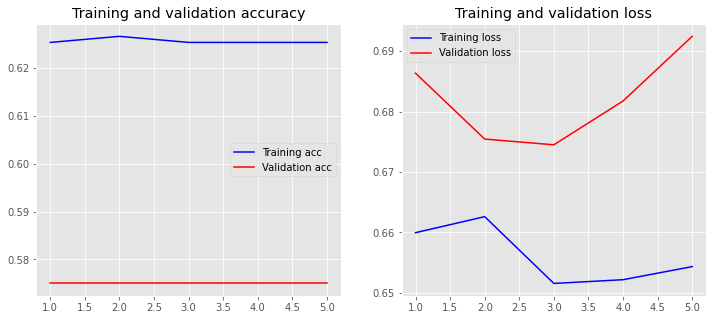

In [155]:
plt.style.use('ggplot')

def plot_history(model):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(model)

## Bert Classifier

In [56]:
!pip install -q transformers

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 46.6 MB/s 
     |████████████████████████████████| 3.3 MB 39.2 MB/s 
     |████████████████████████████████| 895 kB 26.5 MB/s 
     |████████████████████████████████| 61 kB 430 kB/s 


In [57]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

import os

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [59]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [62]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



In [63]:
sample = 'از این محصول بدم اومده!'

In [64]:
tokens = tokenizer.tokenize(sample)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

Tokens: از این محصول بدم اومده !
Token IDs: [2791, 2802, 3573, 19910, 36711, 1001]


In [65]:
encoding = tokenizer.encode_plus(
    sample,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  2791,  2802,  3573, 19910, 36711,  1001,     4,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [66]:
class SentimentDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Digikala SentimentDataset. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs

In [67]:
torch.tensor(0, dtype=torch.long)

tensor(0)

In [68]:
def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = SentimentDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [69]:
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(df_train['cat_clean_comment'].to_numpy(), df_train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(df_eval['cat_clean_comment'].to_numpy(), df_eval['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)

In [70]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['پردازنده ذاتا هسته\u200cای توان ساختن هسته مجاز', 'سلام دوستای عزیز عزادار هاتون قبول باشه', 'کلا پولتون نریزیزد', 'صمیم قلب امیدوار دایانا کارن بمونه پوریا فراموش کنه', 'آنطور اپل ادعا آیپاد شافل طراح العاده ادعایی واقعی', 'کفش بدی خودم داد دوخت قیمت کفش ارزش خرید نداره', 'دلیل پنل صفحه نمایش عملکرد زوایا مختلف قبول', 'همکار دانگل خریدهبود گذر روز استفاده میگفت دانگل لگ افت کیفیت برد راحت متصل میشود داغ نمیکند شگفت انگیز ارزش خرید بالا دیجی جان شگفت انگیزش کن چندتا دوستان میخوایم خرید', 'چقد فاصله', 'زود شارژ خال میکنه', 'گوشت استفاده غذا بو نامطبوع سفت ناپخته', 'هست', 'کیفیت', 'لنز توانایی زوم توانایی زوم کمینه کانون لنز حالت واید ٫ باش عکاس شرایط نوری ضعیف عالیست', 'وسیله هست باز جنس پلاستیک ذوق زن', 'زیبا امیدوار شعر زیبا\u200cتری ایشون آ طاقچه بابت رایگان کردن ممنون']
torch.Size([16, 128])
tensor([    2,  7639, 22126,  5115,  3435,  7152,  7276,  5660,     4,     0,
            0,     0,     0,   

In [102]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [103]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Sat Jan  8 19:10:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    77W / 149W |   6585MiB / 11441MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [104]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [106]:
# sample data output

sample_data_comment = sample_data['comment']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)


# outputs = F.softmax(
#     pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids), 
#     dim=1)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

print(preds)

tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')


In [78]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

In [119]:
from sklearn.metrics import f1_score
def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

In [108]:
def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss

In [110]:
def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss

In [111]:
def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [112]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)

In [113]:
total_steps = len(train_data_loader) * EPOCHS

In [114]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [115]:
loss_fn = nn.CrossEntropyLoss()

In [116]:
def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb

In [117]:
import collections
from tqdm.notebook import tqdm

In [120]:
step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)

for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/13 [00:00<?, ?it/s]

Training... :   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/13 [00:00<?, ?it/s]

Training... :   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/13 [00:00<?, ?it/s]

In [121]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [127]:
test_comments = df_eval['cat_clean_comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)


  0%|          | 0/7 [00:00<?, ?it/s]

(200,) (200, 2)


In [128]:
df_eval

,index,comment,rate,clean_comment,label,cat_clean_comment
0,61591,کیفیت غذا و زمان رسیدن عالی بود,-1.0,"[کیفیت, غذا, زمان]",negative,کیفیت غذا زمان
1,50299,در‌ حد ساندویچ یه نفره بود نه دونفره یا بمب. ک...,1.0,"[در, ساندویچ, یه, نفره, دونفره, بمب, کیفیت, مع...",positive,در ساندویچ یه نفره دونفره بمب کیفیت معمولی حجم...
2,2777,طعم پیتزای چهار فصل مثل همشه خیلی خوب بود اما ...,-1.0,"[طعم, پیتزا, فصل, همشه, سیب, زمین, پنیر, اصلا]",negative,طعم پیتزا فصل همشه سیب زمین پنیر اصلا
3,9126,مشخصات سخت افزاری مناسب در کنار سیستم عامل وین...,0.5,"[مشخصات, سخت, افزار, سیستم, عامل, ویندوز, گوش,...",positive,مشخصات سخت افزار سیستم عامل ویندوز گوش گوش طرف...
4,7544,مرغش سوخاری و خوشمزه بود، بسته بندی عالی، قیمت...,-1.0,"[مرغ, سوخاری, خوشمزه, بسته, قیمت, سرعت, ارسال]",negative,مرغ سوخاری خوشمزه بسته قیمت سرعت ارسال
...,...,...,...,...,...,...
195,3939,خود کتاب داستان جذابی نداشت و ترجمه جلال کار ر...,-0.6,"[کتاب, داستان, جذاب, دار, ترجمه, جلال, کار, بد]",negative,کتاب داستان جذاب دار ترجمه جلال کار بد
196,44573,زرشک پلو به شدت شور بود. یعنی شور بودا …. فک ک...,1.0,"[زرشک, پلو, شدت, شور, شور, بودا, فک, یه, ملاقه...",positive,زرشک پلو شدت شور شور بودا فک یه ملاقه نمک خورد...
197,8871,دوربین دوربین ۵ مگاپیکسلی iSight با لنز F۲٫۴ و...,1.0,"[دوربین, دوربین, مگاپیکسلی, لنز, ٫, سنسور, تبل...",positive,دوربین دوربین مگاپیکسلی لنز ٫ سنسور تبلت کیفیت...
198,3837,من بالاخره این گوشیو می‌خرم قیمتشم برام مهم نیست.,0.5,"[بالاخره, گوشیو, خر, قیمت, برام]",positive,بالاخره گوشیو خر قیمت برام


In [131]:
eval_y

[array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1]),
 array([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1,

In [135]:
print(f'F1: {f1_score(eval_y, preds, average="weighted")}')
print()
print(classification_report(eval_y, preds, target_names=label_list))

F1: 0.6673980703392468

              precision    recall  f1-score   support

    negative       0.62      0.56      0.59        85
    positive       0.70      0.75      0.72       115

    accuracy                           0.67       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.67      0.67      0.67       200

